# Handwriting Recognition Demo
Given a PDF of Handwritten text, the system recognises the text. It is done by Page Segmentation, Word and Line Segmentation, Handriting Character Recognition and Language Modeling.

Input: a pdf of handritten text

Output: recognised text

## Import from Google Drive
import required files and code from our google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Requirements Installation

In [2]:
!pip install -r "/content/drive/MyDrive/handwritten-text-recognition/requirements.txt"

In [3]:
!pip install pdf2image

In [4]:
!apt install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.12).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


## Convert PDF into Image

In [6]:
from pdf2image import convert_from_path
pages = convert_from_path('/content/drive/MyDrive/answer sheets pdf/11.pdf', 500)
#Convert pdf into images
#Saving pages in jpeg format
cnt=0
for i,page in enumerate(pages):
    y="/content/drive/MyDrive/images/"+str(i)+"im.jpeg"
    page.save(y, 'JPEG')
    cnt+=1

In [7]:
import cv2
import glob
import numpy as np
from PIL import Image
images = []
files = glob.glob ("/content/drive/MyDrive/images/*.jpeg")
for myFile in files:
    print(myFile)
    image = Image.open(myFile)
    new_image = image.resize((2479, 3542))
    new_image.save(myFile)
    image = cv2.imread(myFile, cv2.IMREAD_GRAYSCALE)
    images.append (image)
imag=np.array(images)
print(' shape:', imag.shape)

/content/drive/MyDrive/images/0im.jpeg
 shape: (1, 3542, 2479)


In [8]:
%cd /content/drive/MyDrive/handwritten-text-recognition

/content/drive/MyDrive/handwritten-text-recognition


## Import Libraries and Modules
Import required libraries and functions defined in various python files

In [9]:
import difflib
import importlib
import math
import random
import string

random.seed(123)

import gluonnlp as nlp
import leven
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
from skimage import transform as skimage_tf, exposure
from tqdm import tqdm

from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.sclite_helper import ScliteHelper
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
from ocr.utils.beam_search import ctcBeamSearch

import ocr.utils.denoiser_utils
import ocr.utils.beam_search

importlib.reload(ocr.utils.denoiser_utils)
from ocr.utils.denoiser_utils import SequenceGenerator

importlib.reload(ocr.utils.beam_search)
from ocr.utils.beam_search import ctcBeamSearch


from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding

In [10]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()

In [11]:
random.seed(1)

## Input Image of Handwritten text

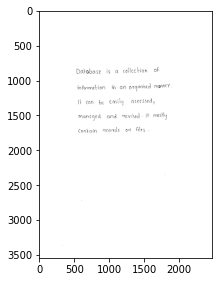

In [12]:
plt.figure(figsize=(10,10)) 

for i in range(cnt):
    plt.subplot(2,2,i+1)   
    plt.imshow(imag[i], cmap='Greys_r')

## Page segmentation

In [13]:
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)

In [14]:
paragraph_segmentation_net.hybridize()

(3542, 2479)
bb_predicted :  [0.13320693 0.19736405 0.7452675  0.3207384 ]
predicted (x,y,w,h) :  (275.7944439840317, 501.25375474244345, 1959.369247815609, 1534.6748311370613)


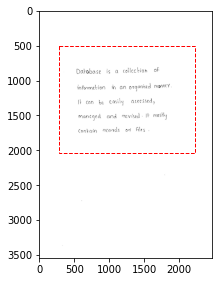

In [15]:
from matplotlib.patches import Rectangle
form_size = (1120, 800)

predicted_bbs = []
plt.figure(figsize=(10,10)) 
for i, image in enumerate(imag):
  print(image.shape)
  resized_image = paragraph_segmentation_transform(image, form_size)
  bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
  bb_predicted = bb_predicted[0].asnumpy()
  print("bb_predicted : ",bb_predicted)
  bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.06, expand_bb_scale_y=0.35)
  predicted_bbs.append(bb_predicted)

  (x, y, w, h) = bb_predicted
  image_h, image_w = image.shape[-2:]
  (x, y, w, h) = (x * image_w+1, y * image_h+1, w * image_w+1, h * image_h+1)
  print("predicted (x,y,w,h) : ",(x, y, w, h))
  rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
  
  plt.subplot(2,2,i+1)    
  plt.imshow(imag[i], cmap='Greys_r')
  plt.gca().add_patch(rect)
 


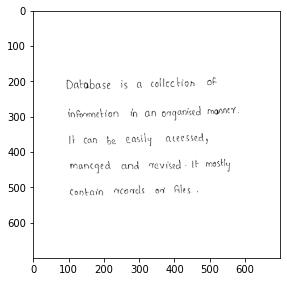

In [16]:
segmented_paragraph_size = (700, 700)
plt.figure(figsize=(10,10))
paragraph_segmented_images = []

for i, image in enumerate(images):
    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    plt.subplot(2,2,i+1)    
    plt.imshow(image, cmap='Greys_r')

## Word & Line Segmentation

In [17]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

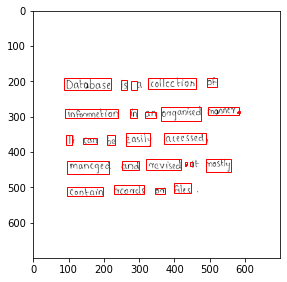

In [18]:
min_c = 0.1
overlap_thres = 0.1
topk = 600
plt.figure(figsize=(10,10))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    predicted_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)
    predicted_words_bbs_array.append(predicted_bb)
    plt.subplot(2,2,i+1)   
    plt.imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):     
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        plt.gca().add_patch(rect)

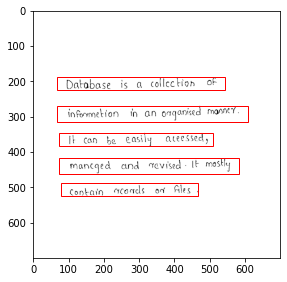

In [19]:
#Line segmentation : merging bounding boxes of words to bounding box of line
line_images_array = []
plt.figure(figsize=(10,10))
for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    plt.subplot(2,2,i+1)    
    plt.imshow(paragraph_segmented_image, cmap='Greys_r')
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        plt.gca().add_patch(rect)

## Handwritten Character Recognition

In [20]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

In [21]:
line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

In [22]:
#greedy algorithm convert the output of the handwriting recognition network into strings (based on maximum probability)
def get_arg_max(prob): 
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [23]:
def get_beam_search(prob, width=5):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width)
    return possibilities[0]

In [24]:
FEATURE_LEN = 150
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=FEATURE_LEN, max_tgt_length=FEATURE_LEN, num_heads=16, embed_size=256, num_layers=2)
denoiser.load_parameters('models/denoiser2.params', ctx=ctx)

In [25]:
denoiser.hybridize(static_alloc=True)

In [ ]:
#Language model 
ctx_nlp = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()
language_model, vocab = nlp.model.big_rnn_lm_2048_512(dataset_name='gbw', vocab='/content/drive/MyDrive/gbw-ebb1a287.vocab', pretrained=True, ctx=ctx_nlp)
moses_tokenizer = nlp.data.SacreMosesTokenizer()
moses_detokenizer = nlp.data.SacreMosesDetokenizer()

In [27]:
beam_sampler = nlp.model.BeamSearchSampler(beam_size=20,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=EOS,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)

In [28]:
generator = SequenceGenerator(beam_sampler, language_model, vocab, ctx_nlp, moses_tokenizer, moses_detokenizer)

In [29]:
def get_denoised(prob, ctc_bs=False):
    if ctc_bs: 
        text = get_beam_search(prob)
    else:
        text = get_arg_max(prob)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = generator.generate_sequences(inputs, states, text)[::2]
    return output.strip()

## Handwritten Text Recognition

[GS] Database is a collcction of
[LS] Database is a collection of
[GS] informetion in an orrganised mannex.
[LS] information in an organised manner.
[GS] It can be easily aceessed,
[LS] It can be easily accessed,
[GS] mancged and revised. It mostiy
[LS] managed and revised. It mostly
[GS] cantain rcorrds onr files.
[LS] contain records or files.


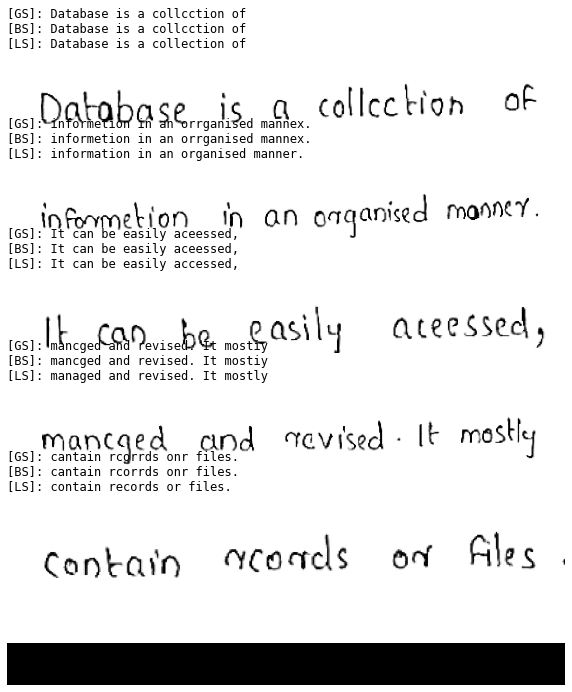

In [30]:
#Handwritten text recognition from probability of characters predicted
#GS-->Greedy Search (maximum probability character selected)
#BS-->Beam Search (selecting K top probability of characters)
#LS-->Lexicon Search (denoising text using language model)
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        print("[GS]",decoded_line_am)
        decoded_line_bs = get_beam_search(line_character_probs)
        decoded_line_denoiser = get_denoised(line_character_probs, ctc_bs=False)
        print("[LS]",decoded_line_denoiser)
        
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].set_title("[GS]: {}\n[BS]: {}\n[LS]: {}\n\n".format(decoded_line_am, decoded_line_bs, decoded_line_denoiser), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')